### Matrix factoring algorithm in Keras
This code is based on the approach outlined in [Alkahest](http://www.fenris.org/)'s blog post [Collaborative Filtering in Keras](http://www.fenris.org/2016/03/07/index-html).
![deeplearningmodel](images/deeplearningmodel.png)


#### Embedding
[Word Embedding](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
are a family of natural language processing techniques aiming at mapping semantic meaning into a geometric space. This is done by associating a numeric vector to every word in a dictionary, such that the distance (e.g. L2 distance or more commonly cosine distance) between any two vectors would capture part of the semantic relationship between the two associated words. The geometric space formed by these vectors is called an embedding space.
![embedding](images/embedding.png)

As described above, I used embedding layer for sequential models, like sentiment analysis, image recogniztion. Since it can verctorize your phrase or image, also capture their features. But here the reason it used embedding is we can learn a low-dimensional representation (embedding) of user and movie.
In general, here is what we want: get a matrix (A [M X N]) containing users and movies for ratings.
And here is approach using embedding: we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: A≈W.HT

Intuitively, we can understand embeddings as low dimensional hidden factors for movies and users. For e.g. say we have 3 dimensional embeddings for both movies and users.

For instance, for movie A, the 3 numbers in the movie embedding matrix represent 3 different characteristics about the movie, such as:

    How recent is the movie A?
    How much special effects are in movie A?
    How CGI-driven is movie A?
    For user B, the 3 numbers in the user embedding matrix represent:

    How much does user B like Drama movie?
    How likely does user B to give a 5-star rating?
    How often does user B watch movies?

### Pre process datasets

In [3]:
# Import libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

# Reading ratings file
ratings = pd.read_csv('rating.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Reading ratings file
users = pd.read_csv('user.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading ratings file
movies = pd.read_csv('movie.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [31]:
# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=0)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
#print 'Users:', Users, ', shape =', Users.shape
print(Users)
print(Users.shape)
# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
#print 'Movies:', Movies, ', shape =', Movies.shape
print(Movies)
print(Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
#print 'Ratings:', Ratings, ', shape =', Ratings.shape
print(Ratings)
print(Ratings.shape)

[1921 4917  956 ... 2663 1819 5953]
(1000209,)
[2093 2807 1659 ...  647    0 1274]
(1000209,)
[4 1 4 ... 4 5 5]
(1000209,)


### Create model

In [41]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
import numpy as np
from keras.layers import Embedding, Reshape, dot, Input, concatenate
from keras.models import Sequential
from keras.models import Model, load_model

k_factors = 100

def build_model2(K_FACTORS = 3, max_userid = 0 , max_movieid = 0, lr=0.0, lr_d=0.0):
    print(K_FACTORS, max_userid, max_movieid)

    file_path = "./best_model.hdf5"
    check_point = ModelCheckpoint(file_path, save_best_only = True)
    early_stop = EarlyStopping(monitor = "val_loss", patience = 2)
    
    user_in = Input(shape = (1,))
    user_embed = Embedding(max_userid, k_factors, input_length=1)(user_in)
    #user_reshape = Reshape((k_factors,))(user_embed)
    user_reshape = keras.layers.Flatten(name='FlattenUser')(user_embed)


    movie_in = Input(shape = (1,))
    movie_embed = Embedding(max_movieid, k_factors, input_length=1)(movie_in)
    #movie_reshape = Reshape((k_factors,))(movie_embed)
    movie_reshape = keras.layers.Flatten(name='FlattenMovies')(movie_embed)


    # The Merge layer takes the dot product of user and movie latent factor vectors to return the corresponding rating.
    product = dot([movie_reshape, user_reshape], axes = 1, normalize=False)
    model = Model(inputs = [user_in, movie_in], outputs = product)
    #model.compile(loss='mse', optimizer = Adam(lr = lr, decay = lr_d))
    model.compile(loss='mse', optimizer='adamax')

    model.fit([Users, Movies], Ratings, epochs=30, validation_split=.1, verbose=2, callbacks = [check_point])
    
    model = load_model(file_path)

    return model

In [42]:
trained_model = build_model2(max_userid = max_userid, max_movieid = max_movieid, K_FACTORS = 100)


100 6040 3952
Train on 900188 samples, validate on 100021 samples
Epoch 1/30
 - 270s - loss: 8.3572 - val_loss: 2.3240
Epoch 2/30
 - 273s - loss: 1.5022 - val_loss: 1.1421
Epoch 3/30
 - 267s - loss: 1.0045 - val_loss: 0.9466
Epoch 4/30
 - 264s - loss: 0.8909 - val_loss: 0.8803
Epoch 5/30
 - 265s - loss: 0.8422 - val_loss: 0.8474
Epoch 6/30
 - 268s - loss: 0.8107 - val_loss: 0.8261
Epoch 7/30
 - 267s - loss: 0.7862 - val_loss: 0.8097
Epoch 8/30
 - 267s - loss: 0.7645 - val_loss: 0.7988
Epoch 9/30
 - 269s - loss: 0.7441 - val_loss: 0.7871
Epoch 10/30
 - 269s - loss: 0.7235 - val_loss: 0.7786
Epoch 11/30
 - 267s - loss: 0.7032 - val_loss: 0.7697
Epoch 12/30
 - 267s - loss: 0.6827 - val_loss: 0.7628
Epoch 13/30
 - 277s - loss: 0.6626 - val_loss: 0.7578
Epoch 14/30
 - 272s - loss: 0.6421 - val_loss: 0.7542
Epoch 15/30
 - 267s - loss: 0.6213 - val_loss: 0.7514
Epoch 16/30
 - 275s - loss: 0.6005 - val_loss: 0.7517
Epoch 17/30
 - 279s - loss: 0.5800 - val_loss: 0.7515
Epoch 18/30
 - 269s - los

In [44]:
trained_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 100)       395200      input_18[0][0]                   
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 100)       604000      input_17[0][0]                   
__________________________________________________________________________________________________
FlattenMov

### Visualize the Arch

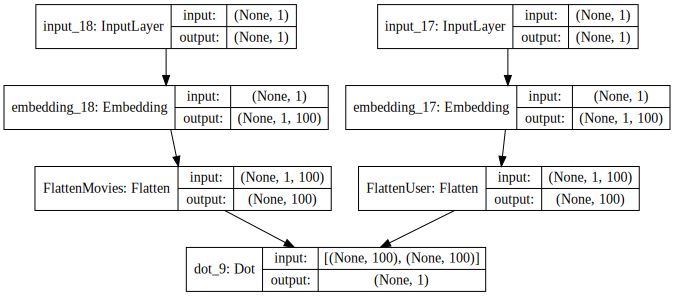

In [45]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(trained_model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


### Train the Model

In [46]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
    return trained_model.predict([np.array([user_id]), np.array([movie_id])])

In [67]:
predict_rating(1,150)

array([[3.385388]], dtype=float32)

In [77]:
# Function to predict the ratings given User ID and Movie ID
def rate(trained_model, user_id, item_id):
        return trained_model.predict([np.array([user_id]), np.array([item_id])])[0][0]
def predict_rating(user_id, movie_id):
    return rate(trained_model, user_id - 1, movie_id - 1)
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m'])

,user_id,movie_id,rating,prediction,title,genres
0,1,1193,5,4.528349,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,1029,5,3.900159,Dumbo (1941),Animation|Children's|Musical
2,1,1,5,4.419713,Toy Story (1995),Animation|Children's|Comedy
3,1,3105,5,4.308270,Awakenings (1990),Drama
4,1,1961,5,4.443284,Rain Man (1988),Drama
5,1,527,5,4.786564,Schindler's List (1993),Drama|War
6,1,1022,5,4.128540,Cinderella (1950),Animation|Children's|Musical
7,1,1035,5,4.475653,"Sound of Music, The (1965)",Musical
8,1,48,5,3.501671,Pocahontas (1995),Animation|Children's|Musical|Romance
9,1,1028,5,4.263278,Mary Poppins (1964),Children's|Comedy|Musical


In [52]:

recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(100)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(1000)

,movie_id,prediction,title,genres
0,2904,[[5.227778]],Rain (1932),Drama
1,3091,[[5.157628]],Kagemusha (1980),Drama|War
2,667,[[5.084515]],Bloodsport 2 (1995),Action
3,1422,[[5.0275016]],Murder at 1600 (1997),Mystery|Thriller
4,668,[[5.0158334]],Pather Panchali (1955),Drama
5,3133,[[5.0114393]],Go West (1925),Comedy
6,3337,[[4.985895]],I'll Never Forget What's 'is Name (1967),Comedy|Drama
7,669,[[4.934769]],Aparajito (1956),Drama
8,3469,[[4.9300904]],Inherit the Wind (1960),Drama
9,758,[[4.924553]],"Jar, The (Khomreh) (1992)",Drama
